## Homework

In [92]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1OKFSv2GpuUFDphO0r8LdM7bl6MAWwBfX' -O data.csv

"wget" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.
"id" �� ���� ����७��� ��� ���譥�
��������, �ᯮ��塞�� �ணࠬ��� ��� ������ 䠩���.


В этой домашней работе вы будете предсказывать стоимость домов по их характеристикам.

Метрика качества: `RMSE`

Оценивание:
* Baseline - 2 балла
* Feature Engineering - 2 балла
* Model Selection - 3 балла
* Ensemble v.1 - 3 балла
* (*) Ensemble v.2 - дополнительно, 2 балла

### Описание датасета

Короткое описание данных:
```
price: sale price (this is the target variable)
id: transaction id
timestamp: date of transaction
full_sq: total area in square meters, including loggias, balconies and other non-residential areas
life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas
floor: for apartments, floor of the building
max_floor: number of floors in the building
material: wall material
build_year: year built
num_room: number of living rooms
kitch_sq: kitchen area
state: apartment condition
product_type: owner-occupier purchase or investment
sub_area: name of the district

The dataset also includes a collection of features about each property's surrounding neighbourhood, and some features that are constant across each sub area (known as a Raion). Most of the feature names are self explanatory, with the following notes. See below for a complete list.

full_all: subarea population
male_f, female_f: subarea population by gender
young_*: population younger than working age
work_*: working-age population
ekder_*: retirement-age population
n_m_{all|male|female}: population between n and m years old
build_count_*: buildings in the subarea by construction type or year
x_count_500: the number of x within 500m of the property
x_part_500: the share of x within 500m of the property
_sqm_: square meters
cafe_count_d_price_p: number of cafes within d meters of the property that have an average bill under p RUB
trc_: shopping malls
prom_: industrial zones
green_: green zones
metro_: subway
_avto_: distances by car
mkad_: Moscow Circle Auto Road
ttk_: Third Transport Ring
sadovoe_: Garden Ring
bulvar_ring_: Boulevard Ring
kremlin_: City center
zd_vokzaly_: Train station
oil_chemistry_: Dirty industry
ts_: Power plant
```

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import HuberRegressor
from sklearn import tree, metrics, model_selection
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set_style("darkgrid")


In [2]:
df = pd.read_csv("data.csv", parse_dates=["timestamp"])

In [3]:
df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price
0,0,2014-12-26,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,36,7,2,15,33,1,12,75,10,15318960
1,1,2012-10-04,64,64.0,16.0,NaN,NaN,NaN,NaN,NaN,...,2,2,0,0,13,1,0,6,1,6080000
2,2,2014-02-05,83,44.0,9.0,17.0,1.0,1985.0,3.0,10.0,...,13,6,1,8,18,0,1,52,0,17000000
3,3,2012-07-26,71,49.0,2.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,1,3,0,2,8,2,990000
4,4,2014-10-29,60,42.0,9.0,9.0,1.0,1970.0,3.0,6.0,...,3,1,0,5,8,0,1,34,5,7900000


Разделите имеющиеся у вас данные на обучающую и тестовую выборки. В качестве обучающей выборки возьмите первые 80% данных, последние 20% - тестовая выборка.

In [4]:
target = ['price']
X = df.drop(target, axis=1)
y = df[target]

In [5]:
# May leak information
drop_columns = [
    'id',
    'timestamp',
]
# categorical columns
cat_columns = [
    'product_type','material','state','sub_area','culture_objects_top_25',
    'thermal_power_plant_raion','incineration_raion', 'oil_chemistry_raion','radiation_raion',
    'railroad_terminal_raion','big_market_raion','nuclear_reactor_raion','detention_facility_raion',
    'ID_metro','ID_railroad_station_walk','ID_railroad_station_avto','water_1line',
    'ID_big_road1','big_road1_1line','ID_big_road2','railroad_1line','ID_railroad_terminal',
    'ID_bus_terminal','ecology',
]

num_columns = list(set(X.columns).difference(set(cat_columns + drop_columns)))

In [6]:
num_columns

['0_13_all',
 'kitch_sq',
 'cafe_count_1500',
 'stadium_km',
 'sport_count_1500',
 '16_29_all',
 'sport_count_2000',
 'shopping_centers_raion',
 'big_road2_km',
 'indust_part',
 'leisure_count_1500',
 'cafe_count_5000_price_1500',
 'market_count_500',
 'cafe_sum_5000_max_price_avg',
 'cafe_sum_1000_min_price_avg',
 'kindergarten_km',
 'green_part_2000',
 '0_6_female',
 'cafe_count_1000_price_500',
 'office_count_1500',
 'cafe_count_1000_price_1500',
 'build_count_frame',
 'build_count_1946-1970',
 'school_education_centers_raion',
 'build_count_1921-1945',
 'leisure_count_3000',
 'market_count_3000',
 'cafe_count_1500_price_4000',
 'build_count_wood',
 'cafe_sum_1500_min_price_avg',
 'church_count_500',
 'sport_count_3000',
 'market_count_2000',
 'public_healthcare_km',
 'sport_count_500',
 'cafe_count_2000',
 'water_km',
 'children_school',
 'cafe_count_1000_price_high',
 'school_quota',
 'mosque_count_1500',
 'cafe_count_5000_na_price',
 'church_count_5000',
 'trc_sqm_2000',
 'cafe_s

In [7]:
X[num_columns] = X[num_columns].fillna(X[num_columns].mean())

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Возможно в ваших моделях вам придется указывать, какие колонки являются категориальными (например, в бустингах). Для упрощения предлагается разделить колонки по следующему принципу:
```
drop_columns = [
    'id',           # May leak information
    'timestamp',    # May leak information
]
cat_columns = [
    'product_type',              #
    'material',                  # Material of the wall
    'state',                     # Satisfaction level
    'sub_area',                  # District name
    'culture_objects_top_25',    #
    'thermal_power_plant_raion', #
    'incineration_raion',        #
    'oil_chemistry_raion',       #
    'radiation_raion',           #
    'railroad_terminal_raion',   #
    'big_market_raion',          #
    'nuclear_reactor_raion',     #
    'detention_facility_raion',  #
    'ID_metro',                  #
    'ID_railroad_station_walk',  #
    'ID_railroad_station_avto',  #
    'water_1line',               #
    'ID_big_road1',              #
    'big_road1_1line',           #
    'ID_big_road2',              #
    'railroad_1line',            #
    'ID_railroad_terminal',      #
    'ID_bus_terminal',           #
    'ecology',                   #
]
num_columns = list(set(df.columns).difference(set(cat_columns + drop_columns)))
```

### Baseline (2 балла)

В качестве Baseline обучите `DecisionTreeRegressor` из `sklearn`.

In [9]:
cls = DecisionTreeRegressor(random_state=42)
cls.fit(X_train[num_columns], y_train)
y_pred = cls.predict(X_train[num_columns])
print(f"RMSE train: {mean_squared_error(y_train, y_pred, squared=False):,}")

RMSE train: 72,947.96082077535


Проверьте качество на отложенной выборке.

In [10]:
y_pred = cls.predict(X_test[num_columns])
print(f"RMSE test: {mean_squared_error(y_test, y_pred, squared=False):,}")

RMSE test: 3,746,693.438144434


Можно заметить, что RMSE на тестовой выборке очень сильно отличается от тренеровочной. То есть произошло переобучение

### Feature Engineering (2 балла)

Часто улучшить модель можно с помощью аккуратного Feature Engineering.

Добавим в модель дополнительные признаки:
* "Как часто в этот год и этот месяц появлились объявления"
* "Как часто в этот год и эту неделю появлялись объявления"

In [11]:
month_year = (df.timestamp.dt.month + df.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df["month_year_cnt"] = month_year.map(month_year_cnt_map)

week_year = (df.timestamp.dt.weekofyear + df.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df["week_year_cnt"] = week_year.map(week_year_cnt_map)

Добавьте следюущие дополнительные признаки:
* Месяц (из колонки `timestamp`)
* День недели (из колонки `timestamp`)
* Отношение "этаж / максимальный этаж в здании" (колонки `floor` и `max_floor`)
* Отношение "площадь кухни / площадь квартиры" (колонки `kitchen_sq` и `full_sq`)

По желанию можно добавить и другие признаки.

In [12]:
df["week"] = df.timestamp.dt.month
df["day_of_week"] = df.timestamp.dt.dayofweek
df["floor/max_floor"] = df.floor / df.max_floor
df["kitchen/full_sq"] = df.kitch_sq / df.full_sq

In [13]:
df["avg_room_sq"] = df.full_sq / df.num_room                            # средняя площадь комнат
df["avg_pre&school_km"] = (df['preschool_km'] + df['school_km']) / 2    # среднее расстояние до школы либо садика
df["part_work_from_full"] = df["work_all"] / df["full_all"]             # отношение рабочее население / все население 
df["part_young_from_full"] = df["young_all"] / df["full_all"]           # отношение молодое население / все население
df["exist_year"] = df["timestamp"].dt.year - df["build_year"]           # сколько лет в нем жили люди до момента сделки

Разделите выборку на обучающую и тестовую еще раз (потому что дополнительные признаки созданы для исходной выборки).

In [14]:
target = ['price']
X = df.drop(target, axis=1)
y = df[target]

In [15]:
num_columns += [
    "week", "day_of_week", "floor/max_floor", "kitchen/full_sq",
    "avg_room_sq", "avg_pre&school_km", "part_work_from_full",
    "part_young_from_full", "exist_year"]

X[num_columns] = X[num_columns].replace([np.inf, -np.inf], np.nan)
X[num_columns] = X[num_columns].fillna(X[num_columns].mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Selection (3 балла)

Посмотрите, какого качества можно добиться если использовать разные модели:
* `DecisionTreeRegressor` из `sklearn`
* `RandomForestRegressor` из `sklearn`
* `CatBoostRegressor`

Также вы можете попробовать линейные модели, другие бустинги (`LigthGBM` и `XGBoost`).

Почти все библиотеки поддерживают удобный способ подбора гиперпараметров: посмотрите как это делать в [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) или в [catboost](https://catboost.ai/docs/concepts/python-reference_catboostregressor_grid_search.html).

Проверяйте качество каждой модели на тестовой выборке и выберите наилучшую.

In [16]:
def root_mean_squared_error(y_true, y_pred):
    error = mean_squared_error(y_true, y_pred, squared=False)
    return error

rmse = make_scorer(root_mean_squared_error)

In [17]:
best_scores = dict()

### DecisionTreeRegressor

In [18]:
param_dectree = {
    'max_depth' : np.arange(1, 20, 2),
    'min_samples_leaf' : np.arange(1, 30, 3),
    'max_features' : ['sqrt', 'log2', 'auto', *np.arange(50, 250, 50)]
}

In [19]:
search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_dectree,
    cv=5,
    n_jobs=-1,
    scoring=rmse
)

search.fit(X_train[num_columns], y_train)
print(f"best param: {search.best_params_} \nbest score RMSE: {search.best_score_:,}")

best param: {'max_depth': 1, 'max_features': 50, 'min_samples_leaf': 1} 
best score RMSE: 4,543,203.511718079


In [20]:
best_reg = DecisionTreeRegressor(random_state=42).set_params(**search.best_params_)
best_reg.fit(X_train[num_columns], y_train)
y_pred = best_reg.predict(X_test[num_columns])

print(f"RMSE test: {root_mean_squared_error(y_test, y_pred):,}")

RMSE test: 4,272,468.300931882


In [21]:
best_scores["DecisionTree"] = root_mean_squared_error(y_test, y_pred)

### RandomForestRegressor

In [22]:
param_randforest = {
    'max_depth' : np.arange(1, 10, 3),
    'min_samples_leaf' : np.arange(1, 10, 3),
    'max_features' : ['sqrt', 'log2', 'auto'],
    'n_jobs' : [-1]
}

In [23]:
search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_randforest,
    cv=5,
    n_jobs=-1,
    scoring=rmse
)

search.fit(X_train[num_columns], y_train)
print(f"best param: {search.best_params_} \nbest score RMSE: {search.best_score_:,}")

best param: {'max_depth': 1, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_jobs': -1} 
best score RMSE: 4,407,540.230841051


In [24]:
best_reg = RandomForestRegressor(random_state=42).set_params(**search.best_params_)
best_reg.fit(X_train[num_columns], y_train)
y_pred = best_reg.predict(X_test[num_columns])

print(f"RMSE test: {root_mean_squared_error(y_test, y_pred):,}")

RMSE test: 4,150,823.9880283484


In [25]:
best_scores["RandomForest"] = root_mean_squared_error(y_test, y_pred)

### CatBoostRegressor

In [26]:
param_catboost = {
    'learning_rate': [0.5, 1],
    'depth': [1, 2, 3],
    'l2_leaf_reg': [1, 2, 3]
}

In [30]:
search = CatBoostRegressor().grid_search(
    param_catboost,
    X=X_train[num_columns], 
    y=y_train, 
    plot=True,
    verbose=False
)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 5577850.9119880	test: 5345553.6293567	best: 5345553.6293567 (0)	total: 15.8ms	remaining: 15.8s
1:	learn: 4382723.1031358	test: 4155984.2260726	best: 4155984.2260726 (1)	total: 32.8ms	remaining: 16.4s
2:	learn: 3942134.8324762	test: 3731684.9267924	best: 3731684.9267924 (2)	total: 45ms	remaining: 15s
3:	learn: 3751293.4097668	test: 3552067.4667721	best: 3552067.4667721 (3)	total: 57.3ms	remaining: 14.3s
4:	learn: 3639761.9058603	test: 3442596.7437951	best: 3442596.7437951 (4)	total: 72ms	remaining: 14.3s
5:	learn: 3542202.9108297	test: 3376056.5855086	best: 3376056.5855086 (5)	total: 86.9ms	remaining: 14.4s
6:	learn: 3485330.3563869	test: 3319943.3140176	best: 3319943.3140176 (6)	total: 102ms	remaining: 14.5s
7:	learn: 3440534.8548596	test: 3275281.0804042	best: 3275281.0804042 (7)	total: 115ms	remaining: 14.3s
8:	learn: 3386801.4352354	test: 3223737.0585965	best: 3223737.0585965 (8)	total: 130ms	remaining: 14.3s
9:	learn: 3345792.3198844	test: 3180605.3783661	best: 3180605.37

In [31]:
best_catboost = CatBoostRegressor().set_params(**search['params'])
best_catboost.fit(X_train[num_columns], y_train, silent=True)
y_pred = best_catboost.predict(X_test[num_columns])
print(f"RMSE test: {root_mean_squared_error(y_test, y_pred):,}")

RMSE test: 2,855,469.00051325


In [32]:
best_catboost.get_params()

{'loss_function': 'RMSE', 'depth': 3, 'l2_leaf_reg': 1, 'learning_rate': 0.5}

In [33]:
best_scores["Catboost"] = root_mean_squared_error(y_test, y_pred)

### LightGBM

In [34]:
params_LGBM = {
    'num_leaves' : np.arange(30, 35),
    'max_depth' : np.arange(1, 4),
    'learning_rate' : [0.1, 0.3]
}

In [35]:
search = GridSearchCV(
    estimator=LGBMRegressor(),
    param_grid=params_LGBM,
    cv=5, 
    scoring=rmse,
    n_jobs=-1
)
search.fit(X_train[num_columns], y_train)
print(f"best param: {search.best_params_} \nbest score RMSE: {search.best_score_:,}")

best param: {'learning_rate': 0.1, 'max_depth': 1, 'num_leaves': 30} 
best score RMSE: 3,140,482.3510332434


In [36]:
best_reg = LGBMRegressor().set_params(**search.best_params_)
best_reg.fit(X_train[num_columns], y_train)
y_pred = best_reg.predict(X_test[num_columns])

print(f"RMSE test: {root_mean_squared_error(y_test, y_pred):,}")

RMSE test: 3,001,370.913461453


In [37]:
best_scores["LGBM"] = root_mean_squared_error(y_test, y_pred)

### XGBboost

In [38]:
regressor = XGBRegressor()
regressor.fit(X_train[num_columns], y_train)
y_pred = regressor.predict(X_train[num_columns])

print(f"RMSE train: {root_mean_squared_error(y_train, y_pred):,}")

RMSE train: 1,276,462.429604508


In [39]:
y_pred = regressor.predict(X_test[num_columns])

print(f"RMSE test: {root_mean_squared_error(y_test, y_pred):,}")

RMSE test: 2,664,107.8236838738


In [40]:
best_scores["XGB"] = root_mean_squared_error(y_test, y_pred)

### Лучшая модель

Теперь визуализируем полученные результаты с каждой модели и определим лучшую

Text(0, 0.5, 'RMSE')

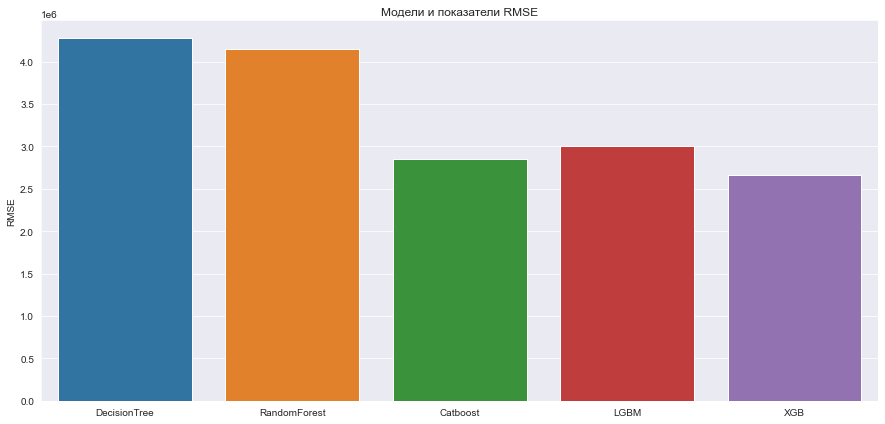

In [41]:
plt.figure(figsize=(15, 7))

sns.barplot(list(best_scores.keys()), list(best_scores.values()))

plt.title("Модели и показатели RMSE")
plt.ylabel("RMSE")

**Выводы**
- XGB при параметрах по умолчанию показал себя лучше всех
- в целом бустеры показали лучший результат
- CatBoost по моим наблюдениям мог показать лучше результаты, если бы можно было расширить param_grid, однако мой все вылетало. Я в такие мгновения замечала цифру ~2,400,000. Мне пришлось уменьшить подбор гиперпараметров
- хуже всех оказалось DecisionTree

### Ensemble v.1 (3 балла)

Ансамбли иногда оказываются лучше чем одна большая модель.

В колонке `product_type` содержится информация о том, каким является объявление: `Investment` (продажа квартиры как инвестиции) или `OwnerOccupier` (продажа квартиры для жилья). Логично предположить, что если сделать по модели на каждый из этих типов, то качество будет выше.

Обучите свои лучшие модели на отдельно на `Investment` и `OwnerOccupier` (т.е. у вас будет `model_invest`, обученная на `(invest_train_X, invest_train_Y)` и `model_owner`, обученная на `(owner_train_X, owner_train_Y)`) и проверьте качество на отложенной выборке (т.е. на исходном `test_split`).

In [42]:
X.product_type.value_counts()

Investment       12840
OwnerOccupier     7160
Name: product_type, dtype: int64

In [43]:
invest_train_X = X[X["product_type"] == 'Investment'][num_columns]
invest_train_y = y[X["product_type"] == 'Investment']

owner_train_X = X[X["product_type"] == 'OwnerOccupier'][num_columns]
owner_train_y = y[X["product_type"] == 'OwnerOccupier']

In [44]:
model_invest = XGBRegressor()
model_invest.fit(invest_train_X, invest_train_y)
y_pred_invest = model_invest.predict(X_test[num_columns])

print(f"RMSE invest test: {root_mean_squared_error(y_test, y_pred_invest):,}")

RMSE invest test: 2,113,034.001953314


In [45]:
model_owner = XGBRegressor()
model_owner.fit(owner_train_X, owner_train_y)
y_pred_owner = model_owner.predict(X_test[num_columns])

print(f"RMSE owner test: {root_mean_squared_error(y_test, y_pred_owner):,}")

RMSE owner test: 3,148,040.5055229245


In [46]:
print(f"RMSE Ensemble: {root_mean_squared_error(y_test, (y_pred_invest + y_pred_owner)/2):,}")

RMSE: 2,162,693.976199597


Можно заметить, что действительно ошибка упала на целых 500к.

In [54]:
print(f"RMSE XGB: {best_scores['XGB']:,}")

RMSE: 2,664,107.8236838738


### (*) Ensemble v.2 (дополнительно, 2 балла)

Попробуйте сделать для `Investment` более сложную модель: обучите `CatBoostRegressor` и `HuberRegressor` из `sklearn`, а затем сложите их предсказания с весами `w_1` и `w_2` (выберите веса сами; сумма весов равняется 1).

Выберу для CatBoostRegressor лучшие параметры из предыдущих пунктов

In [58]:
catboost = CatBoostRegressor().set_params(**{'depth': 3, 'l2_leaf_reg': 2, 'learning_rate': 0.5})
catboost.fit(invest_train_X, invest_train_y, silent=True)
y_pred_catboost = catboost.predict(X_test[num_columns])
print(f"RMSE catboost test: {root_mean_squared_error(y_test, y_pred_catboost):,}")

RMSE catboost test: 2,280,000.998380315


In [59]:
huber = HuberRegressor()
huber.fit(invest_train_X, invest_train_y)
y_pred_huber = huber.predict(X_test[num_columns])
print(f"RMSE huber test: {root_mean_squared_error(y_test, y_pred_huber):,}")

RMSE huber test: 4,736,155.073025425


Теперь посмотрим, при каких показателях w1 и w2 получаем лучший результат

In [94]:
w1_scores = np.arange(0, 1, 0.05)
y_pred = []

for w1 in w1_scores:
    y_pred.append(root_mean_squared_error(y_test, y_pred_catboost * (1 - w1) + y_pred_huber * w1))

min_rmse = w1_scores[np.argmin(y_pred)]

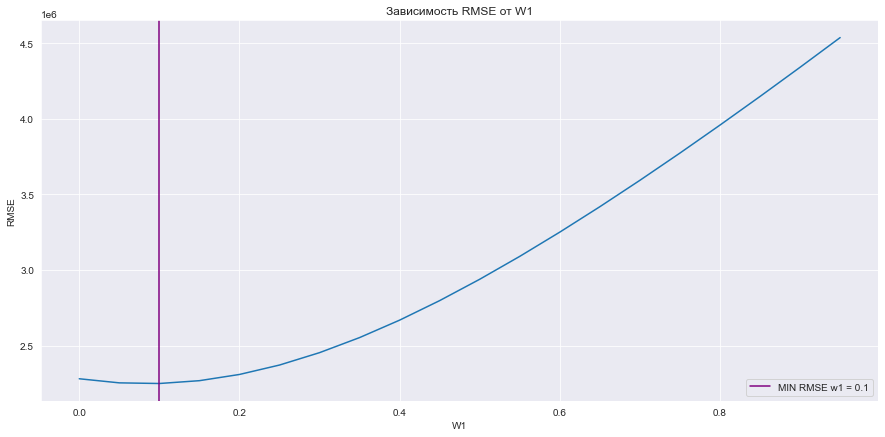

In [95]:
plt.figure(figsize=(15, 7))
plt.plot(w1_scores, y_pred)
plt.axvline(min_rmse, color="purple", label=f"MIN RMSE w1 = {min_rmse}")
plt.title("Зависимость RMSE от W1")
plt.xlabel("W1")
plt.ylabel("RMSE")
plt.legend()
plt.show()

In [96]:
w1 = 0.1
w2 = 1 - w1

In [99]:
y_pred = y_pred_catboost * w2 + y_pred_huber * w1

print(f"RMSE invest test on CatBoostRegressor and HuberRegressor: {root_mean_squared_error(y_test, y_pred):,}")

RMSE invest test on CatBoostRegressor and HuberRegressor: 2,248,626.4790589027


In [104]:
print(f"RMSE Ensemble: {root_mean_squared_error(y_test, (y_pred + y_pred_owner)/2):,}")

RMSE Ensemble: 2,263,956.9768720823


Такой ансамбль показал себя хуже предыдущего, то есть XGBboost пока выигрывает